# Machine Learning estimation for std properties

Based on the Molar Mass, State of Matter, Charge, elements' Entropy, and the number of elements in the chemical formula, we now create machine learning models to predict the standard free Gibbs energy of formation, enthalpy, entropy, and heat capacities.

## Required dependencies

In [1]:
import os
import random

import multiprocessing as mp
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from tqdm.auto import tqdm

import sklearn
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

from pathlib import Path

DATA_PATH = Path(os.environ.get("DATAPATH"))
sklearn.set_config(transform_output="pandas")

pio.renderers.default = "png"

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

2023-12-11 05:34:12.615152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set the number of threads to be used:

In [2]:
available_cpus = mp.cpu_count()
parallel_jobs = available_cpus - 2 if available_cpus > 2 else 1

## Read preprocessed data

### Loading

In [3]:
df_nist_stdprops = pd.read_csv(DATA_PATH / "NBS_Tables_preprocessed.csv", index_col=0)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0
...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0


### Extending with Se (entropy of the elements of the chemical species) and Num of Elements

Reading elements data:

In [4]:
df_nist_elements = pd.read_csv(DATA_PATH / "nist_elements.csv", index_col=0)

df_nist_elements

,element,state,S0
0,O,g,102.569
1,H,g,65.342
2,He,g,126.150
3,Ne,g,146.328
4,Ar,g,154.843
...,...,...,...
123,Li,cr,29.120
124,Na,cr,51.210
125,K,cr,64.180
126,Rb,cr,76.780


In [5]:
def parse_chemical_formula(formula: str) -> dict[str, int]:
    """
    Convenient function to parser and get the amount of elements in
    chemical species formulas.
    """
    import re
    from collections import defaultdict
    
    # Function to parse a molecule or sub-molecule
    def parse_molecule(molecule, multiplier=1):
        elements = re.findall(r'([A-Z][a-z]*)(\d*)', molecule)
        for element, count in elements:
            count = int(count) if count else 1
            element_counts[element] += count * multiplier

    # Remove HTML charge notations
    formula = re.sub(r'<[^>]+>', '', formula)

    # Split the formula into molecules and process each part
    element_counts = defaultdict(int)
    molecules = formula.split('·')
    
    for molecule in molecules:
        # Handle molecules with and without parentheses
        if '(' in molecule:
            while '(' in molecule:
                # Find and replace the innermost parenthetical expression
                sub_molecule, sub_multiplier = re.search(r'\(([A-Za-z0-9]+)\)(\d*)', molecule).groups()
                sub_multiplier = int(sub_multiplier) if sub_multiplier else 1
                molecule = re.sub(r'\(([A-Za-z0-9]+)\)(\d*)', '', molecule, 1)
                parse_molecule(sub_molecule, sub_multiplier)
        
        # Handle preffix-like multiplier
        else:
            sub_multiplier, sub_molecule = re.search(r'(\d*)([A-Za-z0-9]+)', molecule).groups()
            sub_multiplier = int(sub_multiplier) if sub_multiplier else 1
            molecule = re.sub(r'(\d*)([A-Za-z0-9]+)', '', molecule, 1)
            parse_molecule(sub_molecule, sub_multiplier)
            
        # Process the remaining parts of the molecule
        parse_molecule(molecule)

    return dict(element_counts)

In [6]:
Se_species = []
n_elements_in_species = []
for index, row in df_nist_stdprops.iterrows():
    species_formula = row["Formula"]
    elements_in_species = parse_chemical_formula(species_formula)
    
    elements_S0 = 0.0
    n_elements = 0.0
    try:
        for element, count in elements_in_species.items():
            df_element = df_nist_elements.loc[df_nist_elements['element'] == element]
            elements_S0 += df_element['S0'].values[0] * count
            n_elements += count

    except IndexError:
        print(f"Skipping species {species_formula}: element {element} is lacking")
        elements_S0 = np.nan
        n_elements = np.nan
    
    Se_species.append(elements_S0)
    n_elements_in_species.append(n_elements)
    
df_nist_stdprops["Se"] = Se_species
df_nist_stdprops["Num Elements"] = n_elements_in_species

Skipping species D: element D is lacking
Skipping species D2: element D is lacking
Skipping species HD: element D is lacking
Skipping species OD: element D is lacking
Skipping species D2O: element D is lacking
Skipping species D2O: element D is lacking
Skipping species HDO: element D is lacking
Skipping species YD2: element D is lacking
Skipping species YD3: element D is lacking
Skipping species LiD: element D is lacking
Skipping species LiD: element D is lacking
Skipping species KD: element D is lacking


In [7]:
df_nist_stdprops.head(20)

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge,Se,Num Elements
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0,102.569,1.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0,205.138,2.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0,307.707,3.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0,65.342,1.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0,65.342,1.0
5,D,g,2.0141,221.673,206.506,123.349,20.786,0.0,NaN,NaN
6,H2,g,2.0160,0.000,0.000,130.684,28.824,0.0,130.684,2.0
7,D2,g,4.0282,0.000,0.000,144.960,29.196,0.0,NaN,NaN
8,HD,g,3.0221,0.318,-1.464,143.801,29.196,0.0,NaN,NaN
9,OH,g,17.0074,38.950,34.230,183.745,29.886,0.0,167.911,2.0


In [8]:
df_nist_stdprops.dropna(inplace=True)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge,Se,Num Elements
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0,102.569,1.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0,205.138,2.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0,307.707,3.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0,65.342,1.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0,65.342,1.0
...,...,...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0,296.228,4.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0,3796.748,48.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0,452.979,5.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0,935.983,11.0


## Organizing the data

Separating features and targets:

In [9]:
features_columns = ["Molar Mass", "State", "Charge", "Se", "Num Elements"]
target_columns = ["deltaH0", "deltaG0", "S0", "Cp"]

X = df_nist_stdprops[features_columns]
y = df_nist_stdprops[target_columns]

### Encoding the State of Matter feature

Let's put together state of matter with few occurences (unsure if this is a good approach):

In [10]:
X["State"].value_counts()

State
cr     708
g      523
ai      99
l       74
ao      39
cr2     27
g2      14
cr3      8
l2       7
am       4
g3       2
cr4      2
l3       1
Name: count, dtype: int64

In [11]:
state_renamings = {
    "g2": "g",
    "cr3": "cr",
    "l2": "l",
    "g3": "g",
    "cr4": "cr",
    "l3": "l",
}
X.replace(state_renamings, inplace=True)

/tmp/ipykernel_9671/196545353.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X[["State"]])

encoder_categories = list(encoder.categories_[0])

encoder_categories

['ai', 'am', 'ao', 'cr', 'cr2', 'g', 'l']

In [13]:
X_state_encoded = encoder.transform(X[["State"]])

X_state_encoded

,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1515,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1516,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1517,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1518,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
X_encoded = pd.concat([X, X_state_encoded], axis=1)
X_encoded.drop(columns=["State"], inplace=True)

X_encoded

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
0,15.9994,0.0,102.569,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,31.9988,0.0,205.138,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,47.9982,0.0,307.707,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0080,0.0,65.342,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0080,1.0,65.342,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1515,175.7152,0.0,296.228,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1516,568.1949,0.0,3796.748,48.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1517,302.8044,0.0,452.979,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1518,481.7986,0.0,935.983,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Splitting the data

In [15]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, test_size=test_size)

In [16]:
X_train

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
541,65.3700,0.0,41.630,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1070,24.3120,0.0,32.680,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
820,61.9067,0.0,126.435,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1247,23.9484,0.0,197.031,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1500,168.3584,0.0,196.763,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1139,1004.6432,0.0,3458.218,44.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1305,76.0280,0.0,685.627,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
869,397.9382,0.0,409.627,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1471,124.4726,0.0,344.902,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
y_train

,deltaH0,deltaG0,S0,Cp
541,0.000,0.000,41.630,25.400
1070,147.700,113.100,148.650,20.786
820,-338.100,-309.600,30.250,37.070
1247,-508.480,-450.580,2.800,-79.900
1500,-240.200,-257.800,255.960,36.940
...,...,...,...,...
1139,-13477.000,-12677.000,780.700,769.900
1305,-1019.076,-873.091,195.979,239.410
869,-1878.200,-1789.000,109.960,101.750
1471,-922.600,-855.600,120.080,79.370


## Data scaling

In [18]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_rescaled = scaler.transform(X_train)  
X_test_rescaled = scaler.transform(X_test)  

In [19]:
X_train_rescaled

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
541,-0.708488,-0.073791,-0.664733,-0.675371,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1070,-0.980178,-0.073791,-0.680533,-0.675371,-0.270287,-0.059576,-0.170638,-0.937410,-0.137546,1.338877,-0.242876
820,-0.731406,-0.073791,-0.515023,-0.536110,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1247,-0.982584,-0.073791,-0.390396,-0.396850,3.699772,-0.059576,-0.170638,-0.937410,-0.137546,-0.746894,-0.242876
1500,-0.026991,-0.073791,-0.390870,-0.536110,-0.270287,-0.059576,-0.170638,-0.937410,-0.137546,1.338877,-0.242876
...,...,...,...,...,...,...,...,...,...,...,...
1139,5.506894,-0.073791,5.366723,5.312836,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1305,-0.637962,-0.073791,0.472144,0.438714,-0.270287,-0.059576,-0.170638,-0.937410,-0.137546,-0.746894,4.117327
869,1.492191,-0.073791,-0.015091,-0.118328,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1471,-0.317393,-0.073791,-0.129353,-0.257589,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876


## Build the machine learning model (Neural Network, in this case)

### MLP model setup with `tensorflow`/`keras`

Define the Custom Loss Layer with `Keras` since we need to access the features (`X`):

In [20]:
class CustomLossLayer(Layer):
    def __init__(self, lambda1=1e1, **kwargs):
        super().__init__(**kwargs)
        self.lambda1 = lambda1

    def call(self, inputs):
        y_pred, X_unscaled = inputs

        dG0 = y_pred[:, 1] * 1000
        dH0 = y_pred[:, 0] * 1000
        T = 298.15
        dS0 = y_pred[:, 2] * T

        # Use unscaled features directly
        dSe = X_unscaled[:, 2] * T

        # Compute the GHS L2-residual
        GHS_residual = dG0 - dH0 + dS0 - dSe
        custom_term = tf.norm(GHS_residual, ord=2) / tf.cast(tf.shape(y_pred)[0], tf.float32)

        # Add the custom term to the model's loss
        self.add_loss(self.lambda1 * custom_term)
        return y_pred

Define the model and initialize the custom loss layer architecture:

In [21]:
input_tensor_scaled = Input(shape=(X_train_rescaled.shape[1],))
input_tensor_unscaled = Input(shape=(X_train.shape[1],))

x = Dense(20, activation='relu')(input_tensor_scaled)
x = Dense(30, activation='relu')(x)
x = Dense(20, activation='relu')(x)
x = Dense(10, activation='relu')(x)
y_pred = Dense(4)(x)

custom_loss_layer = CustomLossLayer()([y_pred, input_tensor_unscaled])

Convenient callback functions:

* Progress bar:

In [22]:
class TqdmSingleBarCallback(Callback):
    def __init__(self, total_epochs, training_data=None, **kwargs):
        super().__init__(**kwargs)
        self.total_epochs = total_epochs
        self.training_data = training_data
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.total_epochs, unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the current loss
        current_loss = logs.get('loss') if logs is not None else 0.0

        # Set the progress bar new info
        self.pbar.set_postfix({'loss': f'{current_loss:.4f}'})
        
        # Calculate R^2 score on training data (if provided)
        r2 = 0.0
        if self.training_data is not None:
            X_train, y_train = self.training_data
            y_pred = self.model.predict(X_train)
            r2 = r2_score(y_train, y_pred)
            self.pbar.set_postfix({'loss': f'{current_loss:.4f}', 'R^2': f'{r2:.4f}'})
            
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()
        self.pbar = None

* Early stopping callback:

In [23]:
max_epochs = 20000
min_percentage_of_num_epochs = 0.1
patience = int(max_epochs * min_percentage_of_num_epochs)
early_stopping = EarlyStopping(
    monitor="loss",
    patience=patience,
    verbose=1,
    mode='auto',
)

### Hyperparameter tuning

Before run a full NN models, let's find the best parameters to configure our NN model beforehand.

* Convenient function to use the loss function as score:

In [24]:
def custom_loss_scorer(estimator, X, y):
    X_unscaled = estimator.scaler.inverse_transform(X)
    loss = estimator.model.evaluate([X, X_unscaled], y, verbose=0)
    return -loss  # Negative because lower loss is better

* Reduced configuration to run K-folds cross validations parameter searches:

In [25]:
max_epochs_gs = 3000
min_percentage_of_num_epochs_gs = 0.1
patience_gs = int(max_epochs_gs * min_percentage_of_num_epochs_gs)
early_stopping_gs = EarlyStopping(
    monitor="loss",
    patience=patience_gs,
    verbose=1,
    mode='auto',
)

`sklearn`-compatible model wrapper:

In [26]:
def create_model(X_scaled_and_unscaled: list, learning_rate: float = 0.001):
    X_scaled, X_unscaled = X_scaled_and_unscaled
    input_tensor_scaled = Input(shape=(X_scaled.shape[1],))
    input_tensor_unscaled = Input(shape=(X_unscaled.shape[1],))

    x = Dense(20, activation='relu')(input_tensor_scaled)
    x = Dense(30, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    y_pred = Dense(4)(x)

    custom_loss_layer = CustomLossLayer()([y_pred, input_tensor_unscaled])
    adam_optimizer = Adam(learning_rate=learning_rate)
    model = Model(inputs=[input_tensor_scaled, input_tensor_unscaled], outputs=custom_loss_layer)
    model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
    return model


class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            model_compiler, 
            X_original, 
            learning_rate=0.001, 
            epochs=100, 
            batch_size=32,
            parallel_jobs=-1, 
            verbose=0,
            score_type="mse",
        ):
        self.model_compiler = model_compiler
        self.X_original = X_original
        self.scaler = StandardScaler().fit(X_original)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.parallel_jobs = parallel_jobs
        self.model = None
        self.score_type = score_type

    def fit(self, X, y):
        X_unscaled = self.scaler.inverse_transform(X)
        self.model = self.model_compiler(
            [X, X_unscaled],
            learning_rate=self.learning_rate
        )
        self.model.fit(
            [X, X_unscaled], 
            y, 
            batch_size=self.batch_size,
            epochs=self.epochs, 
            validation_split=0.1,  # to match with PyTorch's approach
            callbacks=[early_stopping_gs],
            workers=self.parallel_jobs, 
            verbose=self.verbose
        )
        return self

    def predict(self, X):
        X_unscaled = self.scaler.inverse_transform(X)
        return self.model.predict([X, X_unscaled], verbose=self.verbose)

    def score(self, X, y):
        X_unscaled = self.scaler.inverse_transform(X)
        if self.score_type == "r2":
            y_pred = self.model.predict([X, X_unscaled], verbose=self.verbose)
            score = r2_score(y, y_pred)
        elif self.score_type == "mse":
            score = -self.model.evaluate([X, X_unscaled], y, verbose=self.verbose)
        else:
            raise ValueError(f"Unavailable score: {self.score_type}")
        return score

In [27]:
model_compiler = create_model
wrapped_model = KerasRegressorWrapper(
    model_compiler, 
    X_original=X_encoded, 
    learning_rate=0.001, 
    epochs=max_epochs_gs,
    batch_size=X_train_rescaled.shape[0],
    parallel_jobs=parallel_jobs,
    score_type="mse"
)

Performing Cross-Validation Randomized Search from `sklearn`:

In [28]:
# 4-folds Shuffling
ss_generator = ShuffleSplit(n_splits=4, test_size=test_size, random_state=1)

In [29]:
lr_values = np.random.uniform(1e-5, 2e-1, 30).tolist()
param_grid = {
    'learning_rate': lr_values,
}

gs = RandomizedSearchCV(
    estimator=wrapped_model, 
    param_distributions=param_grid, 
    scoring={"r2": "r2", "Constrained Loss": custom_loss_scorer},
    refit="Constrained Loss",
    cv=ss_generator, 
    n_iter=10, 
    random_state=42, 
    verbose=3
)

Searching the best learning rate parameter value:

In [30]:
X_full_rescaled = scaler.transform(X_encoded)
gs.fit(
    X_full_rescaled,
    y
)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END learning_rate=0.10285174533833819; Constrained Loss: (test=-134038.484) r2: (test=0.832) total time= 1.3min
Epoch 1215: early stopping
[CV 2/4] END learning_rate=0.10285174533833819; Constrained Loss: (test=-163723.688) r2: (test=0.733) total time=  31.6s
Epoch 1758: early stopping
[CV 3/4] END learning_rate=0.10285174533833819; Constrained Loss: (test=-111768.289) r2: (test=0.830) total time=  44.4s
Epoch 2684: early stopping
[CV 4/4] END learning_rate=0.10285174533833819; Constrained Loss: (test=-109676.719) r2: (test=0.787) total time= 1.1min
[CV 1/4] END learning_rate=0.03668906792558823; Constrained Loss: (test=-96863.281) r2: (test=0.819) total time= 1.2min
[CV 2/4] END learning_rate=0.03668906792558823; Constrained Loss: (test=-143277.500) r2: (test=0.785) total time= 1.2min
Epoch 2549: early stopping
[CV 3/4] END learning_rate=0.03668906792558823; Constrained Loss: (test=-90715.625) r2: (test=0.863) total

RandomizedSearchCV(cv=ShuffleSplit(n_splits=4, random_state=1, test_size=0.25, train_size=None),
                   estimator=KerasRegressorWrapper(X_original=      Molar Mass  Charge        Se  Num Elements  State_ai  State_am  \
0        15.9994     0.0   102.569           1.0       0.0       0.0   
1        31.9988     0.0   205.138           2.0       0.0       0.0   
2        47.9982     0.0   307.707           3.0       0.0       0.0   
3         1.0080     0.0    65.342           1.0       0.0       0.0   
4         1.0080     1.0    65.342           1.0       0.0       0.0   
...          ...     ...       ...           ...       ...       ...   
1515    175.7152     0.0   29...
                                                          0.05825291574820641,
                                                          0.12237446041552867,
                                                          0.027907377191801846,
                                                          0.05843600826055828,
                                                          0.0732787050403054,
                                                          0.09121943614356501,
                                                          0.1570373405189888,
                                                          0.03994275969385037,
                                                          0.10285174533833819,
                                                          0.11848698962671987,
                                                          0.009299618039872344]},
                   random_state=42, refit='Constrained Loss',
                   scoring={'Constrained Loss': <function custom_loss_scorer at 0x7f8fa02647c0>,
                            'r2': 'r2'},
                   verbose=3)

In [31]:
df_parameter_search = pd.DataFrame.from_dict(gs.cv_results_)

df_parameter_search

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_Constrained Loss,split1_test_Constrained Loss,split2_test_Constrained Loss,split3_test_Constrained Loss,mean_test_Constrained Loss,std_test_Constrained Loss,rank_test_Constrained Loss
0,54.626911,17.999081,0.265476,0.015859,0.102852,{'learning_rate': 0.10285174533833819},0.831728,0.733344,0.829828,0.787266,0.795541,0.040069,6,-134038.484375,-163723.687500,-111768.289062,-109676.718750,-129801.794922,21788.014814,3
1,62.881542,12.027734,0.230053,0.018428,0.036689,{'learning_rate': 0.03668906792558823},0.819135,0.785059,0.862646,0.728184,0.798756,0.049156,5,-96863.281250,-143277.500000,-90715.625000,-128539.703125,-114849.027344,21803.215544,1
2,57.420438,17.203851,0.233441,0.024678,0.073279,{'learning_rate': 0.0732787050403054},0.755236,0.839395,0.831180,0.505256,0.732767,0.135389,7,-139163.406250,-135324.781250,-96073.960938,-120826.484375,-122847.158203,16902.649510,2
3,56.916050,9.528833,0.230831,0.036640,0.104956,{'learning_rate': 0.10495603876213125},0.834272,0.748815,0.844158,0.798858,0.806526,0.037334,3,-141403.218750,-210405.937500,-128990.171875,-100625.867188,-145356.298828,40360.079161,7
4,57.890804,9.947949,0.217227,0.001406,0.120227,{'learning_rate': 0.12022699119852433},0.808386,0.777638,0.821717,0.801618,0.802340,0.015990,4,-131987.078125,-129778.054688,-121887.671875,-149175.421875,-133207.056641,9954.440739,4
5,49.028862,13.839439,0.204978,0.009309,0.141617,{'learning_rate': 0.14161743483343114},0.742119,0.797336,0.709476,0.471694,0.680156,0.124385,10,-114944.328125,-290591.843750,-137877.375000,-374666.406250,-229519.988281,107614.130867,10
6,65.917228,7.394366,0.210756,0.007094,0.118487,{'learning_rate': 0.11848698962671987},0.765336,0.825873,0.840726,0.828043,0.814995,0.029226,1,-152379.546875,-178501.750000,-101452.414062,-143270.750000,-143901.115234,27710.004154,6
7,65.888002,5.660161,0.213923,0.004652,0.091219,{'learning_rate': 0.09121943614356501},0.756134,0.783418,0.811315,0.510426,0.715323,0.119895,9,-119807.960938,-183508.109375,-117941.531250,-115751.437500,-134252.259766,28474.096907,5
8,50.999819,15.935809,0.237770,0.011233,0.16649,{'learning_rate': 0.16649020373367635},0.782146,0.678800,0.663518,0.756361,0.720206,0.050179,8,-149496.796875,-373226.343750,-120872.476562,-130720.867188,-193579.121094,104227.865947,9
9,65.376863,6.995812,0.208768,0.008348,0.074914,{'learning_rate': 0.07491427836828402},0.813200,0.807748,0.746929,0.869805,0.809421,0.043499,2,-120730.304688,-266437.125000,-125649.687500,-118731.921875,-157887.259766,62721.834524,8


Collecting the results:

In [32]:
best_lr = gs.best_params_['learning_rate']

print(f"Best lr = {best_lr}")

Best lr = 0.03668906792558823


### Training/testing the model

Initialize and compile the model: 

In [33]:
lr_value = best_lr
adam_optimizer = Adam(learning_rate=lr_value)
model = Model(inputs=[input_tensor_scaled, input_tensor_unscaled], outputs=custom_loss_layer)
model.compile(optimizer=adam_optimizer, loss='mse')

Perform training:

In [34]:
history = model.fit(
    [X_train_rescaled, X_train], 
    y_train, 
    batch_size=X_train_rescaled.shape[0],
    epochs=max_epochs, 
    validation_split=0.1,  # to match with PyTorch's approach
    callbacks=[early_stopping, TqdmSingleBarCallback(max_epochs)],
    workers=parallel_jobs, 
    verbose=0
)

  0%|          | 0/20000 [00:00<?, ?epoch/s]

Run predictions:

In [35]:
y_predict = model.predict(
    [X_test_rescaled, X_test],
    workers=parallel_jobs, 
)

12/12 [==============================] - 0s 1ms/step


In [36]:
dict_y_predict = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict[target] = y_predict[:, id_target]
    
df_y_predict = pd.DataFrame.from_dict(dict_y_predict)

df_y_predict

,deltaH0,deltaG0,S0,Cp
0,61.242500,85.717865,363.663666,94.554672
1,-2271.381836,-2144.105957,104.842880,103.268112
2,4.254126,-22.397036,205.880142,36.461468
3,-55.739693,-37.085373,92.382187,64.354874
4,-312.983337,-320.501953,292.157898,46.126446
...,...,...,...,...
372,347.036865,335.297119,419.617859,50.803570
373,-3421.765137,-3231.440918,104.138245,195.216415
374,-14.958931,-11.076801,39.492088,10.729002
375,-475.526367,-389.337250,79.213951,85.998077


Check the score:

In [37]:
r2_score(y_test, y_predict)

0.7670638071679686

### Evaluate the loss function evolution through the epochs

In [38]:
model_history = history.history
loss_history = model_history['loss']

df_loss_history = pd.DataFrame.from_dict(
    {
        "Epoch": list(range(1, len(loss_history) + 1)), 
        "Loss function evaluations": loss_history,
    }
)

df_loss_history

,Epoch,Loss function evaluations
0,1,1.301196e+06
1,2,1.300849e+06
2,3,1.300326e+06
3,4,1.299142e+06
4,5,1.296597e+06
...,...,...
19995,19996,2.348034e+04
19996,19997,2.318148e+04
19997,19998,2.383411e+04
19998,19999,2.364268e+04


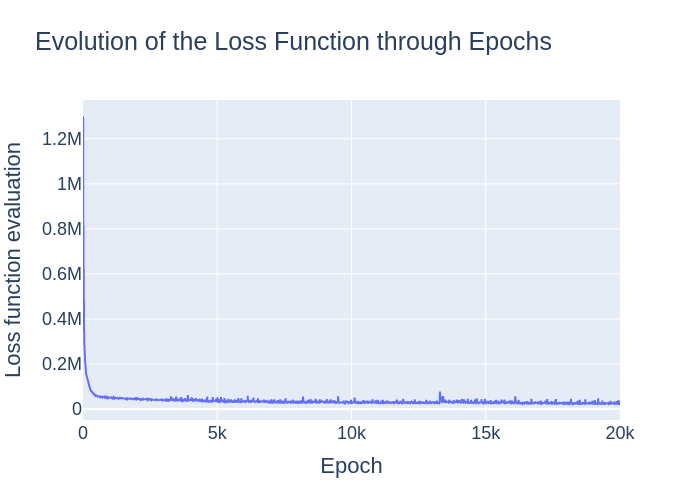

In [39]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history["Epoch"], 
    y=df_loss_history["Loss function evaluations"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the Loss Function through Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss function evaluation",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)

fig.show()

### MLP model setup with `tensorflow` without thermodynamical constrains

Classical NN setup using the same architecture but with pura MSE loss function:

In [40]:
model_unconstrained = Sequential([
    Dense(20, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(30, activation='relu'),
    Dense(20, activation='relu'),
    Dense(10, activation='relu'),
    Dense(4)
])

model_unconstrained.compile(optimizer=Adam(learning_rate=lr_value), loss="mse")

In [41]:
history_unconstrained = model_unconstrained.fit(
    X_train_rescaled, 
    y_train,
    batch_size=X_train_rescaled.shape[0],
    epochs=max_epochs, 
    validation_split=0.1,  # to match with PyTorch's approach
    callbacks=[early_stopping, TqdmSingleBarCallback(max_epochs)],
    workers=parallel_jobs, 
    verbose=0
)

  0%|          | 0/20000 [00:00<?, ?epoch/s]

Epoch 16051: early stopping


In [42]:
y_predict_unconstrained = model_unconstrained.predict(
    X_test_rescaled,
    workers=parallel_jobs, 
)

12/12 [==============================] - 0s 1ms/step


In [43]:
dict_y_predict_unconstrained = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict_unconstrained[target] = y_predict_unconstrained[:, id_target]
    
df_y_predict_unconstrained = pd.DataFrame.from_dict(dict_y_predict_unconstrained)

df_y_predict_unconstrained

,deltaH0,deltaG0,S0,Cp
0,425.118408,426.022400,386.856110,16.432089
1,-1974.821289,-1882.305176,124.938492,119.831528
2,-46.660404,-44.701664,231.904480,47.599846
3,-103.837776,-90.220467,69.855652,57.370506
4,-610.088074,-583.249268,307.486755,108.381012
...,...,...,...,...
372,-267.272400,-248.646851,311.755615,78.281570
373,-2688.987305,-2445.372803,197.380615,191.334854
374,-90.165535,-80.261116,53.430031,39.721336
375,-687.276917,-597.559692,97.540108,92.456291


In [44]:
r2_score(y_test, y_predict_unconstrained)

0.5822129784358218

In [45]:
model_unconstrained_history = history_unconstrained.history
loss_history_unconstrained = model_unconstrained_history['loss']

df_loss_history_constrained = pd.DataFrame.from_dict(
    {
        "Epoch": list(range(1, len(loss_history_unconstrained) + 1)), 
        "Loss function evaluations": loss_history_unconstrained,
    }
)

df_loss_history_constrained

,Epoch,Loss function evaluations
0,1,1.237383e+06
1,2,1.237190e+06
2,3,1.236874e+06
3,4,1.236239e+06
4,5,1.234928e+06
...,...,...
16046,16047,1.741004e+04
16047,16048,1.598190e+04
16048,16049,1.516812e+04
16049,16050,1.608420e+04


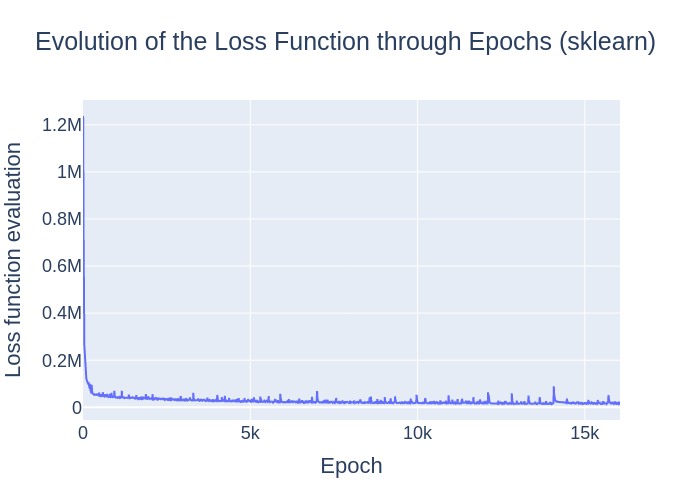

In [46]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history_constrained["Epoch"], 
    y=df_loss_history_constrained["Loss function evaluations"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the Loss Function through Epochs (sklearn)",
    xaxis_title="Epoch",
    yaxis_title="Loss function evaluation",
    font=dict(
        size=18,
    ),
)

fig.show()

## Assess the results

### Collecting results

* Thermodynamics-Informed:

In [47]:
target_errors = {}

for target_name in list(y_test.columns):
    target_abs_error = np.abs(y_test[target_name].values - df_y_predict[target_name].values)
    target_errors[f"{target_name} abs. error"] = target_abs_error
    
    target_rel_error = target_abs_error / np.abs(df_y_predict[target_name].values)
    target_errors[f"{target_name} rel. error"] = target_rel_error
    
df_target_errors = pd.DataFrame.from_dict(target_errors)
df_target_errors

,deltaH0 abs. error,deltaH0 rel. error,deltaG0 abs. error,deltaG0 rel. error,S0 abs. error,S0 rel. error,Cp abs. error,Cp rel. error
0,33.147500,0.541250,60.382135,0.704429,57.663666,0.158563,11.254672,0.119028
1,54.918164,0.024178,64.594043,0.030126,9.377120,0.089440,17.521888,0.169674
2,482.265874,113.364277,478.477036,21.363409,10.879858,0.052846,6.291468,0.172551
3,112.860307,2.024774,108.914627,2.936862,0.757813,0.008203,0.714874,0.011108
4,152.716663,0.487939,150.998047,0.471130,17.557898,0.060097,5.253554,0.113895
...,...,...,...,...,...,...,...,...
372,602.636865,1.736521,564.727119,1.684259,127.087859,0.302866,15.806430,0.311128
373,1847.115137,0.539814,1795.660918,0.555684,30.161755,0.289632,70.996415,0.363681
374,14.958931,1.000000,11.076801,1.000000,1.597912,0.040462,13.110998,1.222015
375,107.726367,0.226541,94.597250,0.242970,31.366049,0.395966,16.548077,0.192424


* Unconstrained:

In [48]:
target_errors_unconstrained = {}

for target_name in list(y_test.columns):
    target_abs_error = np.abs(y_test[target_name].values - df_y_predict_unconstrained[target_name].values)
    target_errors_unconstrained[f"{target_name} abs. error"] = target_abs_error
    
    target_rel_error = target_abs_error / np.abs(df_y_predict_unconstrained[target_name].values)
    target_errors_unconstrained[f"{target_name} rel. error"] = target_rel_error
    
df_target_errors_unconstrained = pd.DataFrame.from_dict(target_errors_unconstrained)
df_target_errors_unconstrained

,deltaH0 abs. error,deltaH0 rel. error,deltaG0 abs. error,deltaG0 rel. error,S0 abs. error,S0 rel. error,Cp abs. error,Cp rel. error
0,330.728408,0.777968,279.922400,0.657060,80.856110,0.209008,66.867911,4.069349
1,351.478711,0.177980,326.394824,0.173402,10.718492,0.085790,0.958472,0.007998
2,533.180404,11.426828,500.781664,11.202752,15.144480,0.065305,17.429846,0.366174
3,64.762224,0.623687,55.779533,0.618258,23.284348,0.333321,6.269494,0.109281
4,144.388074,0.236668,111.749268,0.191598,32.886755,0.106953,57.001012,0.525932
...,...,...,...,...,...,...,...,...
372,11.672400,0.043672,19.216851,0.077286,19.225615,0.061669,11.671570,0.149097
373,1114.337305,0.414408,1009.592803,0.412858,63.080615,0.319589,67.114854,0.350772
374,90.165535,1.000000,80.261116,1.000000,12.340031,0.230957,15.881336,0.399819
375,319.476917,0.464845,302.819692,0.506761,13.039892,0.133687,23.006291,0.248834


In [49]:
target_results = {}

for target_name in list(y_test.columns):
    target_results[f"{target_name} predicted"] = df_y_predict[target_name].values
    target_results[f"{target_name} predicted (unconstrained)"] = df_y_predict_unconstrained[target_name].values
    target_results[f"{target_name} expected"] = y_test[target_name].values
    
df_target_results= pd.DataFrame.from_dict(target_results)
df_target_results

,deltaH0 predicted,deltaH0 predicted (unconstrained),deltaH0 expected,deltaG0 predicted,deltaG0 predicted (unconstrained),deltaG0 expected,S0 predicted,S0 predicted (unconstrained),S0 expected,Cp predicted,Cp predicted (unconstrained),Cp expected
0,61.242500,425.118408,94.39,85.717865,426.022400,146.10,363.663666,386.856110,306.00,94.554672,16.432089,83.30
1,-2271.381836,-1974.821289,-2326.30,-2144.105957,-1882.305176,-2208.70,104.842880,124.938492,114.22,103.268112,119.831528,120.79
2,4.254126,-46.660404,486.52,-22.397036,-44.701664,456.08,205.880142,231.904480,216.76,36.461468,47.599846,30.17
3,-55.739693,-103.837776,-168.60,-37.085373,-90.220467,-146.00,92.382187,69.855652,93.14,64.354874,57.370506,63.64
4,-312.983337,-610.088074,-465.70,-320.501953,-583.249268,-471.50,292.157898,307.486755,274.60,46.126446,108.381012,51.38
...,...,...,...,...,...,...,...,...,...,...,...,...
372,347.036865,-267.272400,-255.60,335.297119,-248.646851,-229.43,419.617859,311.755615,292.53,50.803570,78.281570,66.61
373,-3421.765137,-2688.987305,-1574.65,-3231.440918,-2445.372803,-1435.78,104.138245,197.380615,134.30,195.216415,191.334854,124.22
374,-14.958931,-90.165535,0.00,-11.076801,-80.261116,0.00,39.492088,53.430031,41.09,10.729002,39.721336,23.84
375,-475.526367,-687.276917,-367.80,-389.337250,-597.559692,-294.74,79.213951,97.540108,110.58,85.998077,92.456291,69.45


### Check `deltaH0` results

Against Molar Mass:

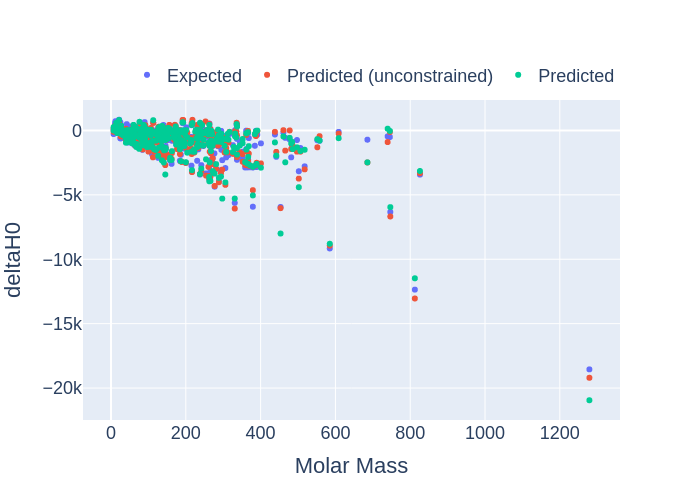

In [50]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="deltaH0",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Against Expected results:

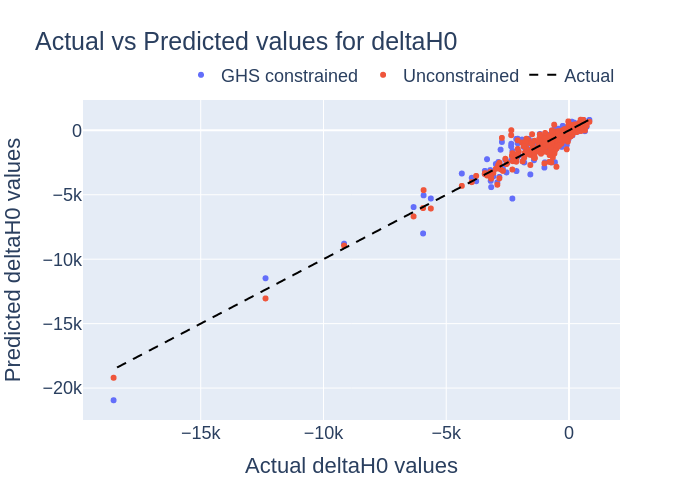

In [51]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for deltaH0",
    xaxis_title="Actual deltaH0 values",
    yaxis_title="Predicted deltaH0 values",
    showlegend=True,
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

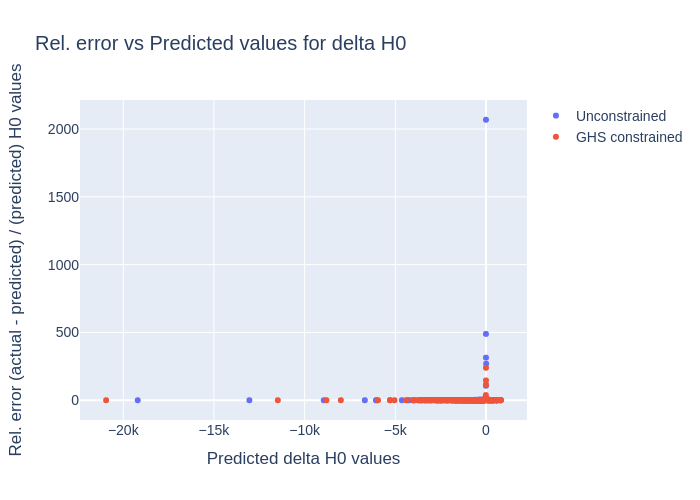

In [52]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaH0 predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["deltaH0 rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaH0 predicted"], 
    y=df_target_errors["deltaH0 rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for delta H0",
    xaxis_title="Predicted delta H0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) H0 values",
    showlegend=True,
    font=dict(
        size=14,
    )
)

fig.show()

`deltaH0` residuals distribution:

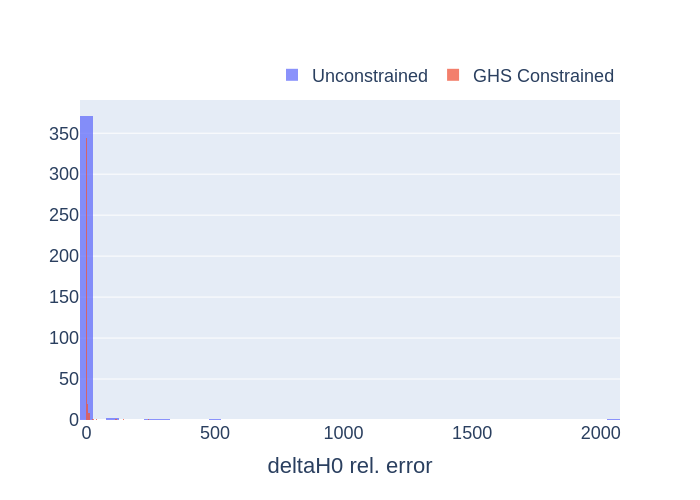

In [53]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["deltaH0 rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["deltaH0 rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="deltaH0 rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Checking `deltaG0` results

Against molar mass:

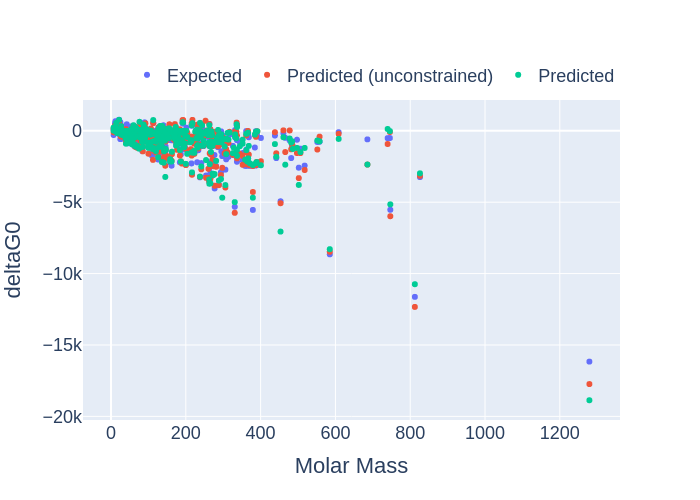

In [54]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="deltaG0",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Against Expected results:

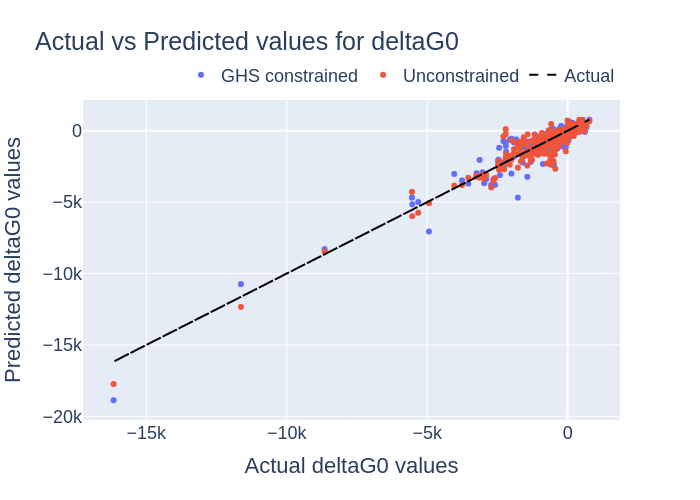

In [55]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for deltaG0",
    xaxis_title="Actual deltaG0 values",
    yaxis_title="Predicted deltaG0 values",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

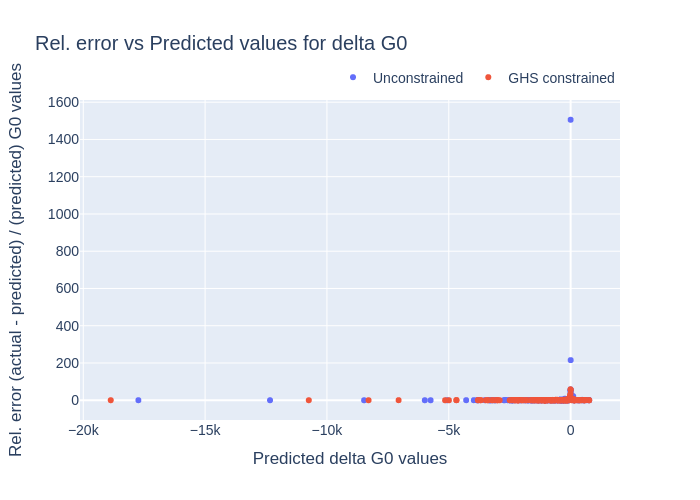

In [56]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaG0 predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["deltaG0 rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaG0 predicted"], 
    y=df_target_errors["deltaG0 rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for delta G0",
    xaxis_title="Predicted delta G0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) G0 values",
    font=dict(
        size=14,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

`deltaG0` residuals distribution:

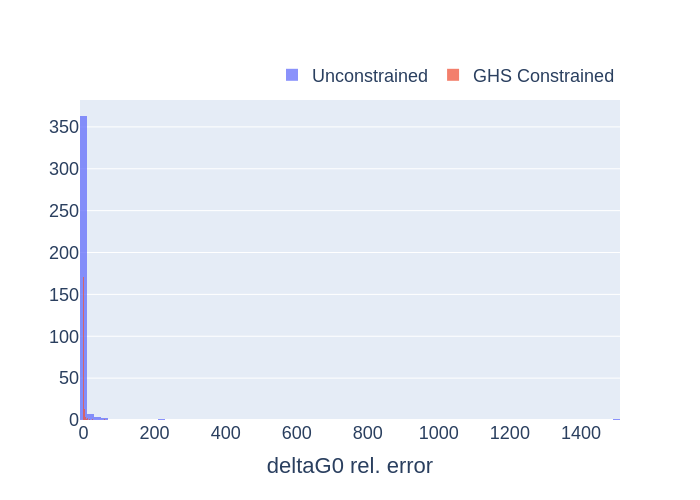

In [57]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["deltaG0 rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["deltaG0 rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="deltaG0 rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Checking `S0` results

Checking against Molar Mass:

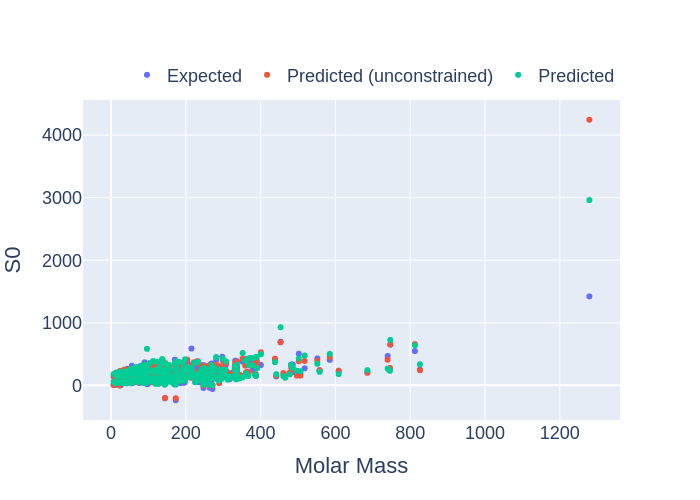

In [58]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="S0",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Checking against expected results:

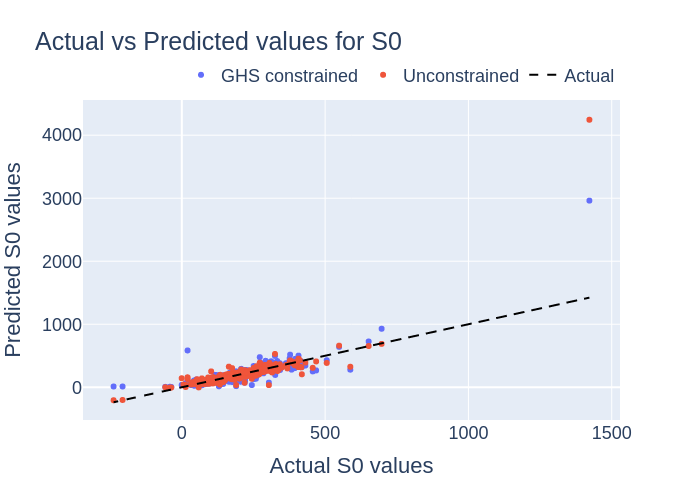

In [59]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for S0",
    xaxis_title="Actual S0 values",
    yaxis_title="Predicted S0 values",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

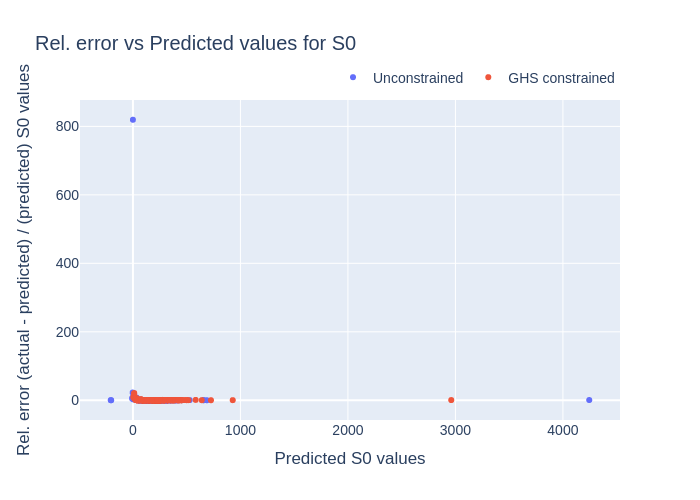

In [60]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["S0 predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["S0 rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["S0 predicted"], 
    y=df_target_errors["S0 rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for S0",
    xaxis_title="Predicted S0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) S0 values",
    font=dict(
        size=14,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

`S0` residuals distribution:

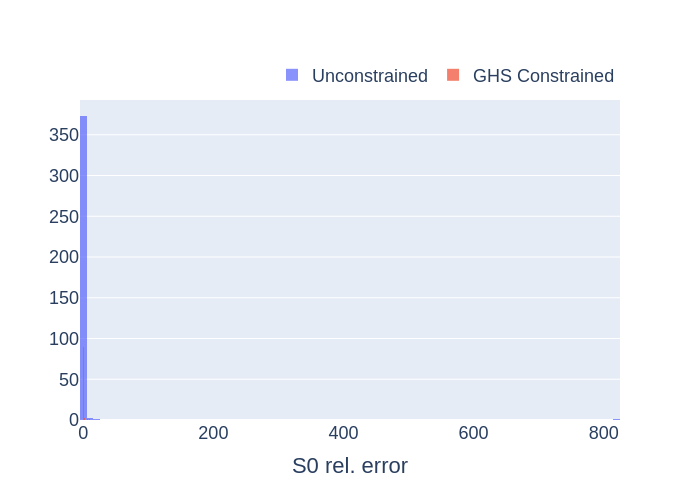

In [61]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["S0 rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["S0 rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="S0 rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Check `Cp` results

Checking against molar mass:

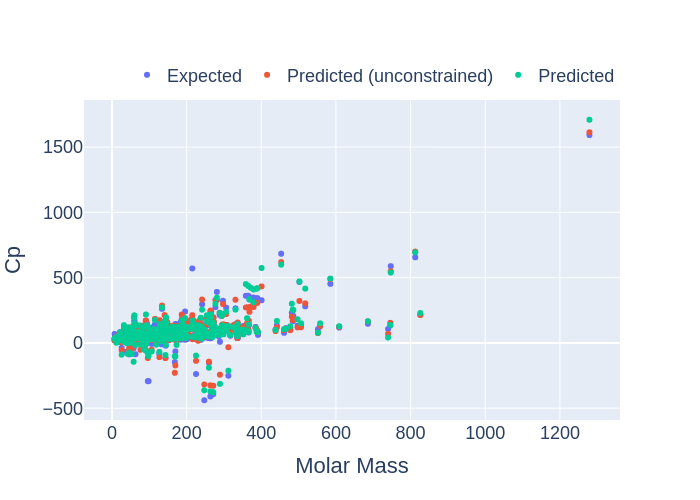

In [62]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="Cp",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Checking against expected results:

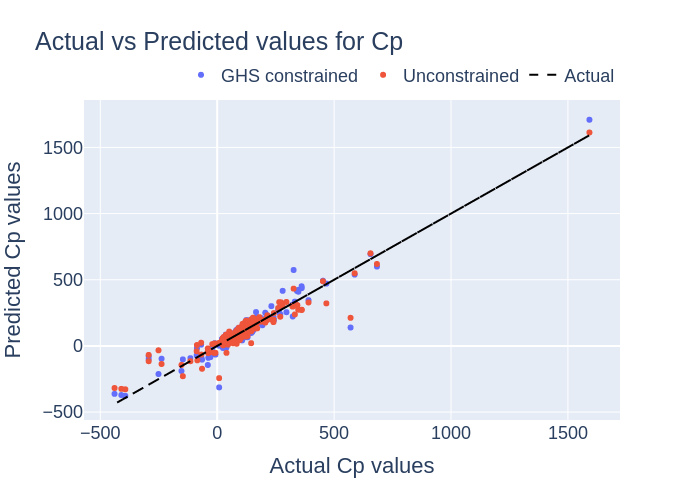

In [63]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for Cp",
    xaxis_title="Actual Cp values",
    yaxis_title="Predicted Cp values",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

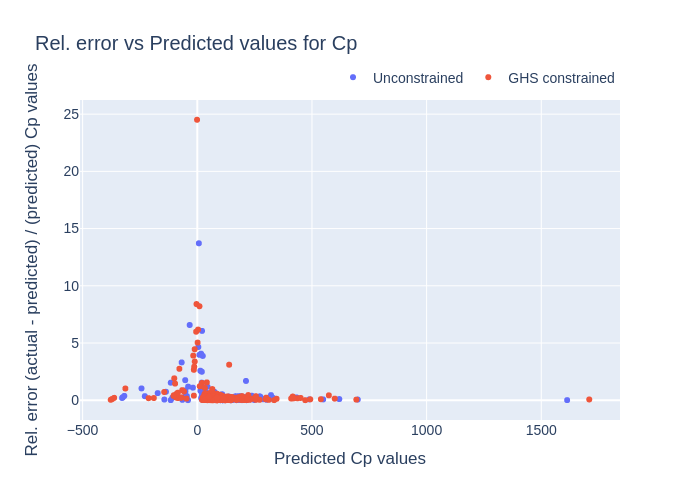

In [64]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["Cp predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["Cp rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["Cp predicted"], 
    y=df_target_errors["Cp rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for Cp",
    xaxis_title="Predicted Cp values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) Cp values",
    font=dict(
        size=14,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

`Cp` residuals distribution:

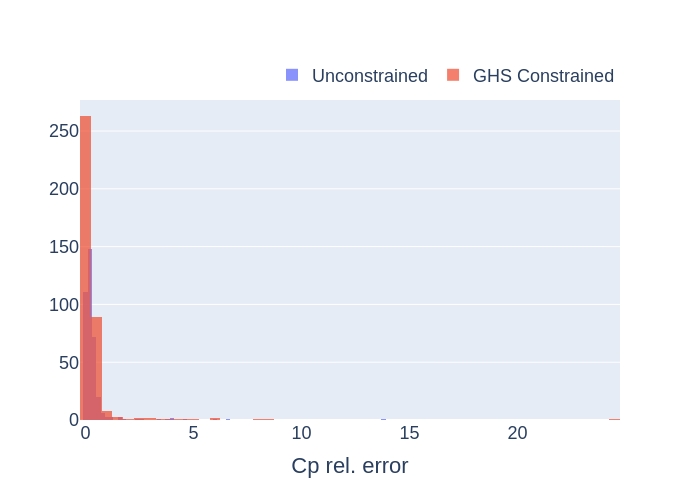

In [65]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["Cp rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["Cp rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="Cp rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Verifying the consistency of the predicted values

To evaluate the quality of the predictions from a thermodynamic point of view, we should assess the GHS residual to check if the predictions are consistent.

* Thermodynamically constrained:

In [66]:
df_predicted_species = df_nist_stdprops.loc[X_test_rescaled.index, ["Formula", "Molar Mass", "Se"]]
for target in list(df_y_predict.columns):
    df_predicted_species.loc[:, target] = df_y_predict.loc[:, target].values
    
df_predicted_species

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp
585,Hg(CH3)2,230.6604,479.5520,61.242500,85.717865,363.663666,94.554672
1155,CaO·Al2O3,158.0406,508.3560,-2271.381836,-2144.105957,104.842880,103.268112
389,SiN,42.0927,114.6350,4.254126,-22.397036,205.880142,36.461468
590,Cu2O,143.0794,168.8690,-55.739693,-37.085373,92.382187,64.354874
975,UO2,270.0278,255.3480,-312.983337,-320.501953,292.157898,46.126446
...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,347.036865,335.297119,419.617859,50.803570
1130,CaSO4·0.5H2O,145.1493,716.7490,-3421.765137,-3231.440918,104.138245,195.216415
162,P,30.9738,41.0900,-14.958931,-11.076801,39.492088,10.729002
1352,NaOCH3,54.0244,355.5450,-475.526367,-389.337250,79.213951,85.998077


* Thermodynamically unconstrained:

In [67]:
df_predicted_species_unconstrained = df_nist_stdprops.loc[X_test_rescaled.index, ["Formula", "Molar Mass", "Se"]]
for target in list(df_y_predict_unconstrained.columns):
    df_predicted_species_unconstrained.loc[:, target] = df_y_predict_unconstrained.loc[:, target].values
    
df_predicted_species_unconstrained

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp
585,Hg(CH3)2,230.6604,479.5520,425.118408,426.022400,386.856110,16.432089
1155,CaO·Al2O3,158.0406,508.3560,-1974.821289,-1882.305176,124.938492,119.831528
389,SiN,42.0927,114.6350,-46.660404,-44.701664,231.904480,47.599846
590,Cu2O,143.0794,168.8690,-103.837776,-90.220467,69.855652,57.370506
975,UO2,270.0278,255.3480,-610.088074,-583.249268,307.486755,108.381012
...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,-267.272400,-248.646851,311.755615,78.281570
1130,CaSO4·0.5H2O,145.1493,716.7490,-2688.987305,-2445.372803,197.380615,191.334854
162,P,30.9738,41.0900,-90.165535,-80.261116,53.430031,39.721336
1352,NaOCH3,54.0244,355.5450,-687.276917,-597.559692,97.540108,92.456291


Collecting the GHS residuals:

In [68]:
T = 298.15  # in K
predicted_GHS_residuals = []
predicted_GHS_residuals_unconstrained = []
expected_GHS_residuals = []
df_expected_stdprops = df_nist_stdprops.loc[X_test_rescaled.index, :]
for index, row in df_predicted_species.iterrows():
    # Skorch
    G0_predicted = row["deltaG0"] * 1000
    H0_predicted = row["deltaH0"] * 1000
    S0_predicted = row["S0"]
    Se_predicted = row["Se"]
    GHS_residual_predicted = G0_predicted - H0_predicted + T * (S0_predicted - Se_predicted)
    predicted_GHS_residuals.append(GHS_residual_predicted)
    
    # Sklearn
    G0_unconstrained = df_predicted_species_unconstrained.loc[index, "deltaG0"] * 1000
    H0_unconstrained = df_predicted_species_unconstrained.loc[index, "deltaH0"] * 1000
    S0_unconstrained = df_predicted_species_unconstrained.loc[index, "S0"]
    Se_unconstrained = df_predicted_species_unconstrained.loc[index, "Se"]
    GHS_residual_predicted_unconstrained = G0_unconstrained - H0_unconstrained + T * (S0_unconstrained - Se_unconstrained)
    predicted_GHS_residuals_unconstrained.append(GHS_residual_predicted_unconstrained)
    
    G0_expected = df_expected_stdprops.loc[index, "deltaG0"] * 1000
    H0_expected = df_expected_stdprops.loc[index, "deltaH0"] * 1000
    S0_expected = df_expected_stdprops.loc[index, "S0"]
    Se_expected = df_expected_stdprops.loc[index, "Se"]
    GHS_residual_expected = G0_expected - H0_expected + T * (S0_expected - Se_expected)
    expected_GHS_residuals.append(GHS_residual_expected)
    
df_predicted_species["GHS residual"] = predicted_GHS_residuals
df_predicted_species_unconstrained["GHS residual"] = predicted_GHS_residuals_unconstrained
df_expected_stdprops["GHS residual"] = expected_GHS_residuals
df_predicted_species

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp,GHS residual
585,Hg(CH3)2,230.6604,479.5520,61.242500,85.717865,363.663666,94.554672,-10076.742165
1155,CaO·Al2O3,158.0406,508.3560,-2271.381836,-2144.105957,104.842880,103.268112,6968.442252
389,SiN,42.0927,114.6350,4.254126,-22.397036,205.880142,36.461468,553.577957
590,Cu2O,143.0794,168.8690,-55.739693,-37.085373,92.382187,64.354874,-4150.223566
975,UO2,270.0278,255.3480,-312.983337,-320.501953,292.157898,46.126446,3456.255351
...,...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,347.036865,335.297119,419.617859,50.803570,-12.803292
1130,CaSO4·0.5H2O,145.1493,716.7490,-3421.765137,-3231.440918,104.138245,195.216415,7674.322036
162,P,30.9738,41.0900,-14.958931,-11.076801,39.492088,10.729002,3405.712301
1352,NaOCH3,54.0244,355.5450,-475.526367,-389.337250,79.213951,85.998077,3801.015205


#### Visual verification

* Thermodynamically constrained:

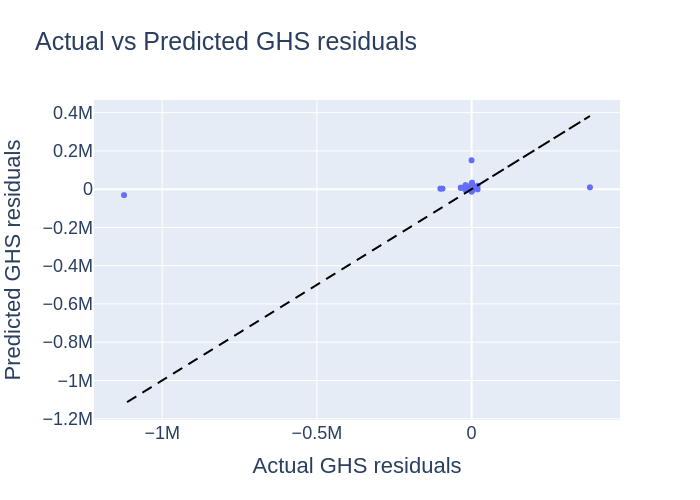

In [69]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_predicted_species["GHS residual"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_expected_stdprops["GHS residual"], 
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted GHS residuals",
    xaxis_title="Actual GHS residuals",
    yaxis_title="Predicted GHS residuals",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

* Thermodynamically unconstrained:

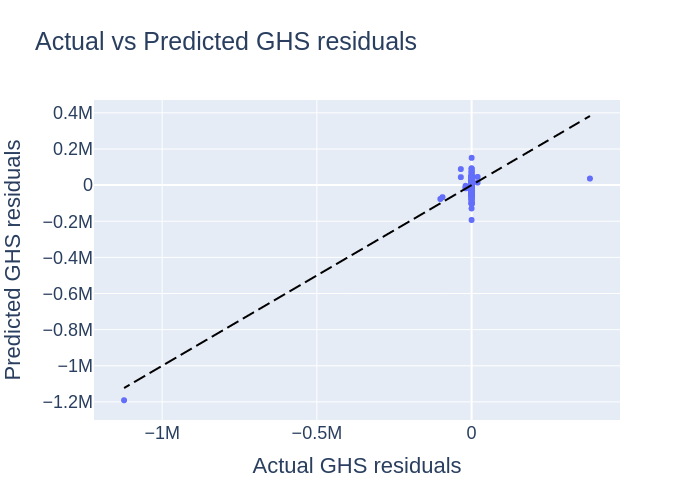

In [70]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_predicted_species_unconstrained["GHS residual"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_expected_stdprops["GHS residual"], 
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted GHS residuals",
    xaxis_title="Actual GHS residuals",
    yaxis_title="Predicted GHS residuals",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

* Consistent vs inconsistent:

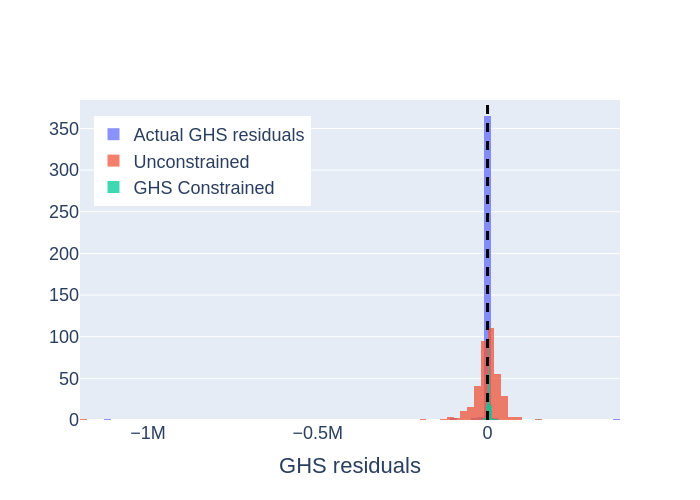

In [71]:
fig = go.Figure()

fig1 = go.Histogram(x=df_expected_stdprops["GHS residual"], name='Actual GHS residuals')
fig2 = go.Histogram(x=df_predicted_species_unconstrained["GHS residual"], name='Unconstrained')
fig3 = go.Histogram(x=df_predicted_species["GHS residual"], name='GHS Constrained')

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    # title="GHS residuals",
    xaxis_title="GHS residuals",
    barmode='overlay',
    # yaxis_title="Predicted GHS residuals",
    # showlegend=False,
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="left",
        x=0.025,
        y=0.95,
    )
)
fig.update_traces(opacity=0.75)
fig.add_vline(x=0.0, line_width=3, line_dash="dash", line_color="black")

fig.show()